- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import os

from ML_loader import DatasetLoader,ModelLoader

In [10]:
#Get data 
loader = DatasetLoader()
#loader.read_dataset('./dataset/partial_database.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./dataset/features_resnet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./dataset/features_googlenet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./dataset/features_mobilenet_large.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./dataset/features_densenet.csv',class_path='labelsDefault.txt',separator=',')
loader.read_dataset('./dataset/features_mobilenet.csv',class_path='labelsDefault.txt',separator=',')

#Normalize data, if needed (if value are negative or too high), only use by mobileNet
loader.X=loader.normalize_features([0,loader.df.shape[1]],"MinMaxScaler")

#loader.add_dataset(file_path='./dataset/features_resnet.csv')
#loader.add_dataset(file_path='./dataset/features_googlenet.csv')
#loader.add_dataset(file_path='./dataset/features_mobilenet.csv')
loader.add_dataset(file_path='./dataset/partial_database.csv')

loader.split_dataset()

#For probability list, add the features used
#features_used=["S_MobileNet"]

print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

(4048, 593) (1012, 593) (4048,) (1012,)


In [11]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)
model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))

In [12]:
print(model.optimal_params)

{'fit_prior': True, 'alpha': 1.3}


Partial fit
[3 6 4 1 7 2 5]
Score accuracy group 0:  0.9658385093167702
Score accuracy group learned 0:  0.9658385093167702
Score accuracy global:  0.31225296442687744
Memory:  390.56640625 MB
Partial fit
[9 8]
Score accuracy group 1:  0.8043478260869565
Score accuracy group learned 0:  0.9658385093167702
Score accuracy group learned 1:  0.8043478260869565
Score accuracy global:  0.391304347826087
Memory:  391.23046875 MB
Partial fit
[12 11 10 13]
Score accuracy group 2:  0.5543478260869565
Score accuracy group learned 0:  0.9192546583850931
Score accuracy group learned 1:  0.7934782608695652
Score accuracy group learned 2:  0.5543478260869565
Score accuracy global:  0.48221343873517786
Memory:  391.48828125 MB
Partial fit
[14 15 16]
Score accuracy group 3:  0.4782608695652174
Score accuracy group learned 0:  0.8944099378881988
Score accuracy group learned 1:  0.75
Score accuracy group learned 2:  0.4945652173913043
Score accuracy group learned 3:  0.4782608695652174
Score accuracy glo

['model.pkl']

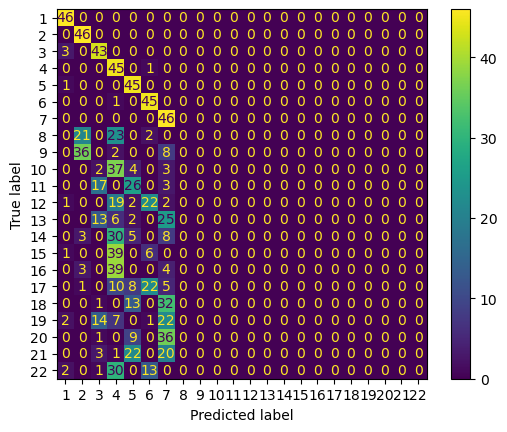

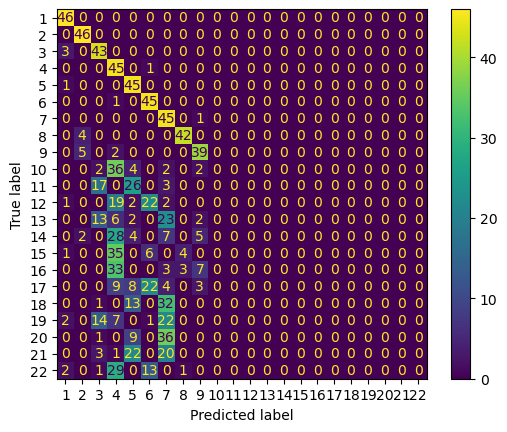

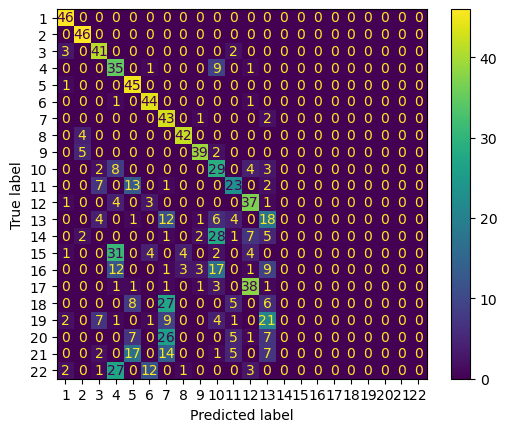

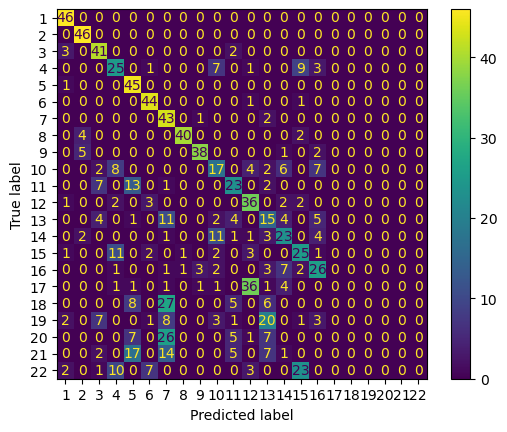

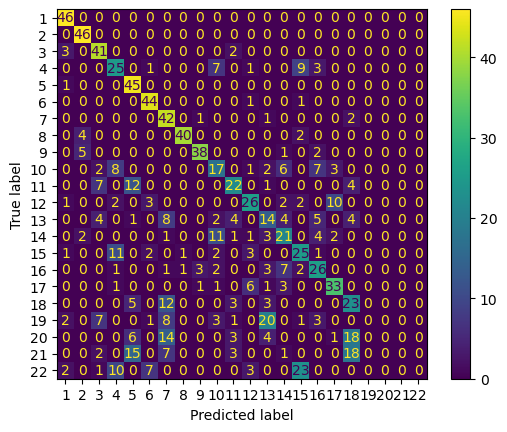

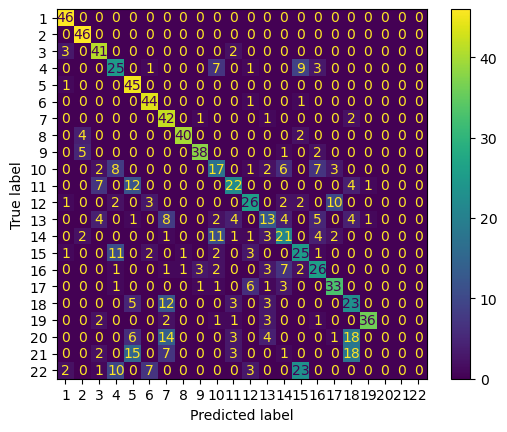

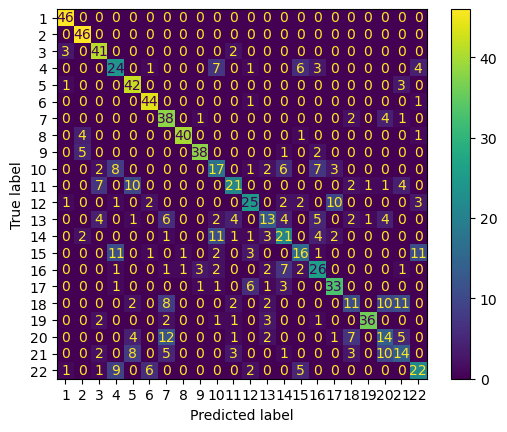

In [13]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7],2:[8,9],3:[10,11,12,13],4:[14,15,16],5:[17,18],6:[19],7:[20,21,22]}
#class_to_group = {1:[1,2,3,4,5,6,7], 2:[8], 3:[9], 4:[10], 5:[11], 6:[12], 7:[13], 8:[14], 9:[15], 10:[16], 11:[17], 12:[18], 13:[19], 14:[20], 15:[21], 16:[22]}

X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []
global_accuracy = []
#Uncomment to get probability list
proba_learned_grouped = []

#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(y_train.unique())
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    global_accuracy.append(model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    #Uncomment to get probability list
    proba_learned_grouped.append(model.predict_proba(loader.X_test))
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(cm,display_labels=loader.classes).plot()    
model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

#Save model
joblib.dump(model.model, 'model.pkl')

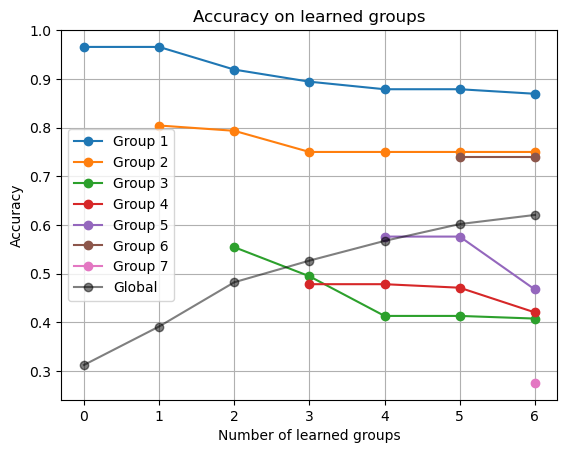

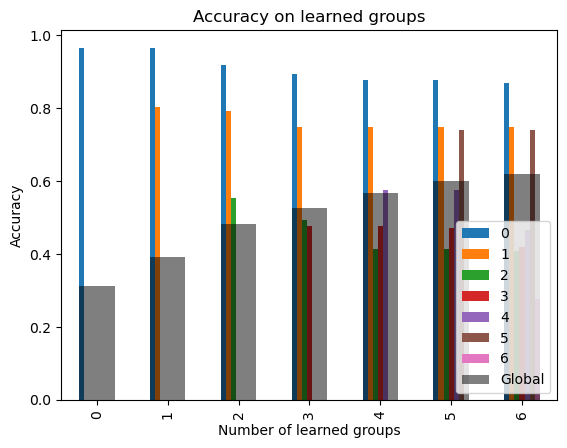

In [14]:
#For learned class
df = pd.DataFrame(accuracy_learned_grouped)
df_bar = df.replace(np.nan, 0)
df_plot=df.T

#For accuracy global

df_global = pd.DataFrame(global_accuracy)
df_global.columns=['Global']
df_global_plot=df_global.T

#Line plot

fig, ax = plt.subplots()

for i in range(len(class_to_group)):
    ax.plot(list(df_plot.iloc[i]),label=f'Group {i+1}',marker='o')

ax.plot(list(df_global_plot.values[0]),label='Global',color='black',alpha=0.5,marker='o')
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')
ax.grid()
ax.legend()

#Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df_bar.plot(kind='bar', ax=ax)
df_global.plot(kind='bar', ax=ax, color='black', alpha=0.5, legend=False)
ax.legend(loc='lower right')

In [15]:
#Pour obtenir les probabilités prédites pour chaque groupe appris/introduit
try:
    os.mkdir(f'./result_proba/') #Creer un dossier pour les résultats
except FileExistsError:
    pass

for i in range(len(proba_learned_grouped)): #Pour obtenir les probabilités prédites pour chaque groupe appris/introduit
    df_proba = pd.DataFrame(proba_learned_grouped[i],columns=loader.classes)
    # Pour obtenir la classe prédite
    def get_max_column(row):     
        return row.idxmax()
    predicted_class = df_proba.apply(get_max_column, axis=1)
    df_proba['y_pred'] = predicted_class
    df_proba = df_proba.assign(y_true=loader.y_test.values)

    df_proba.to_csv(f"result_proba/proba_learned_group_{i}_{len(class_to_group)}.csv",index=False)

In [8]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(cm,display_labels=loader.classes).plot()    
    
model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.